In [1]:
import gymnasium as gym
import numpy as np
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Config():
    def __init__(self):
        # env
        self.env_name = "CartPole-v1"
        self.gamma = 0.99
        self.num_action = 2
        self.state_dim = 4

        # training
        self.total_episodes = 5000
        self.learning_rate = 2.3e-3
        self.weight_decay = 1e-4
        self.epochs = 128
        self.test_frequency = 10
        self.num_test_episodes = 10
        self.save_frequency = 1000
        self.save_path = 'best_model.pth'
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

config = Config()

In [3]:
class Actor(nn.Module):
    def __init__(self, state_dim=4, num_action=2):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.policy = nn.Linear(64, num_action)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        logits = self.policy(x)
        return logits
    
class Critic(nn.Module):
    def __init__(self, state_dim=4, num_action=2):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.value = nn.Linear(64, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        value = self.value(x)
        return value

In [10]:
class Agent():
    def __init__(self, actor_model, critic_model, env, device, learning_rate, weight_decay, total_episodes, 
                 gamma, test_frequency, save_frequency, num_test_episodes, save_path):
        self.actor_model = actor_model
        self.critic_model = critic_model
        self.actor_optimizer = torch.optim.Adam(self.actor_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.critic_optimizer = torch.optim.Adam(self.critic_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        self.env = env
        self.gamma = gamma

        self.total_episodes = total_episodes
        self.test_frequency = test_frequency
        self.save_frequency = save_frequency
        self.num_test_episodes = num_test_episodes
        self.device = device
        config.save_path = save_path

    def sample_action(self, state, is_testing = False):
        with torch.no_grad():
            state = torch.tensor(np.array(state), device = self.device).unsqueeze(0)
            logits = self.actor_model(state)
            if is_testing:
                action = logits[0].argmax(-1).item()
            else:
                probs = torch.softmax(logits, -1)
                distribution = torch.distributions.Categorical(probs)
                action = distribution.sample().cpu().numpy()[0]
        return action

    def play_episode(self, is_testing = False):
        done = False
        state, info = self.env.reset()
        episode_reward = 0.
        states = []
        actions = []
        rewards = []
        while not done:
            action = self.sample_action(state, is_testing)
            next_state, reward, terminated, truncated, info = self.env.step(action)
            episode_reward += reward
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            done = terminated or truncated
            state = next_state
        return episode_reward, states, actions, rewards
    
    def compute_return(self, rewards):
        G = 0
        returns = []
        for reward in rewards[::-1]:
            G = G * self.gamma + reward
            returns.append(G)
        return returns[::-1]
    
    def train(self, states, actions, returns):
        states = torch.tensor(np.array(states), device = self.device)
        returns = torch.tensor(np.array(returns), device = self.device).float()

        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()

        logits = self.actor_model(states)
        values = self.critic_model(states)
        probs = torch.softmax(logits, -1)

        index = torch.arange(0, len(returns), device = self.device)
        actions = torch.tensor(np.array(actions), device = self.device, dtype = torch.int64)

        loss_P = -((probs[index, actions] + 1e-9).log() * (returns - values.detach().reshape(-1))).mean()
        loss_V = torch.nn.functional.mse_loss(values.reshape(-1), returns)

        loss_P.backward()
        loss_V.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.step()

        return loss_P.item(), loss_V.item()

    def learn(self):
        self.episode_rewards = []
        self.test_episode_rewards = []
        self.losses_P = []
        self.losses_V = []
        max_test_rewards = 0.

        for episode in range(1, self.total_episodes+1):
            start_time = datetime.now()
            episode_reward, states, actions, rewards = self.play_episode()
            returns = self.compute_return(rewards)
            loss_P, loss_V = self.train(states, actions, returns)
            self.episode_rewards.append(episode_reward)
            self.losses_P.append(loss_P)
            self.losses_V.append(loss_V)
            if len(self.losses_P) > 100:
                self.losses_P.pop(0)
                self.losses_V.pop(0)

            if episode % 100 == 0:
                print(f"Episode: {episode}, Reward: {episode_reward}, Mean Reward [Last 100]: {np.array(self.episode_rewards)[-min(100, episode):].mean():.4f}, "
                      f"Max Reward: {max(self.episode_rewards)}, Loss P: {np.array(self.losses_P).mean():.4f}, Loss V: {np.array(self.losses_V).mean():.4f}, "
                      f"Episode Time: {datetime.now() - start_time}")
                
            if episode % self.test_frequency == 0:
                start_time = datetime.now()
                for _ in range(1, self.num_test_episodes+1):
                    test_episode_reward, _, _, _ = self.play_episode(is_testing=True)
                    self.test_episode_rewards.append(test_episode_reward)
                mean_test_rewards = np.array(self.test_episode_rewards[-self.test_frequency:]).mean()
                if mean_test_rewards > max_test_rewards:
                    max_test_rewards = mean_test_rewards
                    torch.save(self.actor_model.state_dict(), config.save_path)
                if len(self.test_episode_rewards) % 100 == 0:
                    print(f"Test Episode: {len(self.test_episode_rewards)}, Reward: {episode_reward}, "
                        f"Mean Reward [Last {self.num_test_episodes}]: {np.array(self.test_episode_rewards)[-min(self.num_test_episodes, len(self.test_episode_rewards)):].mean():.4f}, "
                        f"Max Reward: {max_test_rewards}, Test Time: {datetime.now() - start_time}")
                
            if episode % self.save_frequency == 0:
                torch.save(self.actor_model.state_dict(), f"{episode}.pth")

In [11]:
actor_model = Actor(config.state_dim, config.num_action)
critic_model = Critic(config.state_dim, config.num_action)
env = gym.make(config.env_name, render_mode="rgb_array")
agent = Agent(actor_model, critic_model, env, config.device, config.learning_rate, config.weight_decay, config.total_episodes,
              config.gamma, config.test_frequency, config.save_frequency, config.num_test_episodes, config.save_path)

In [12]:
agent.learn()

Episode: 100, Reward: 39.0, Mean Reward [Last 100]: 41.7500, Max Reward: 87.0, Loss P: 5.1356, Loss V: 243.2727, Episode Time: 0:00:00.003901
Test Episode: 100, Reward: 39.0, Mean Reward [Last 10]: 70.8000, Max Reward: 106.8, Test Time: 0:00:00.068983
Episode: 200, Reward: 500.0, Mean Reward [Last 100]: 265.9900, Max Reward: 500.0, Loss P: 3.4737, Loss V: 720.9900, Episode Time: 0:00:00.153988
Test Episode: 200, Reward: 500.0, Mean Reward [Last 10]: 500.0000, Max Reward: 500.0, Test Time: 0:00:00.516705
Episode: 300, Reward: 500.0, Mean Reward [Last 100]: 467.1200, Max Reward: 500.0, Loss P: -0.0169, Loss V: 568.2086, Episode Time: 0:00:00.123789
Test Episode: 300, Reward: 500.0, Mean Reward [Last 10]: 500.0000, Max Reward: 500.0, Test Time: 0:00:00.554156
Episode: 400, Reward: 500.0, Mean Reward [Last 100]: 409.3300, Max Reward: 500.0, Loss P: -0.4005, Loss V: 467.9616, Episode Time: 0:00:00.172751
Test Episode: 400, Reward: 500.0, Mean Reward [Last 10]: 500.0000, Max Reward: 500.0, T

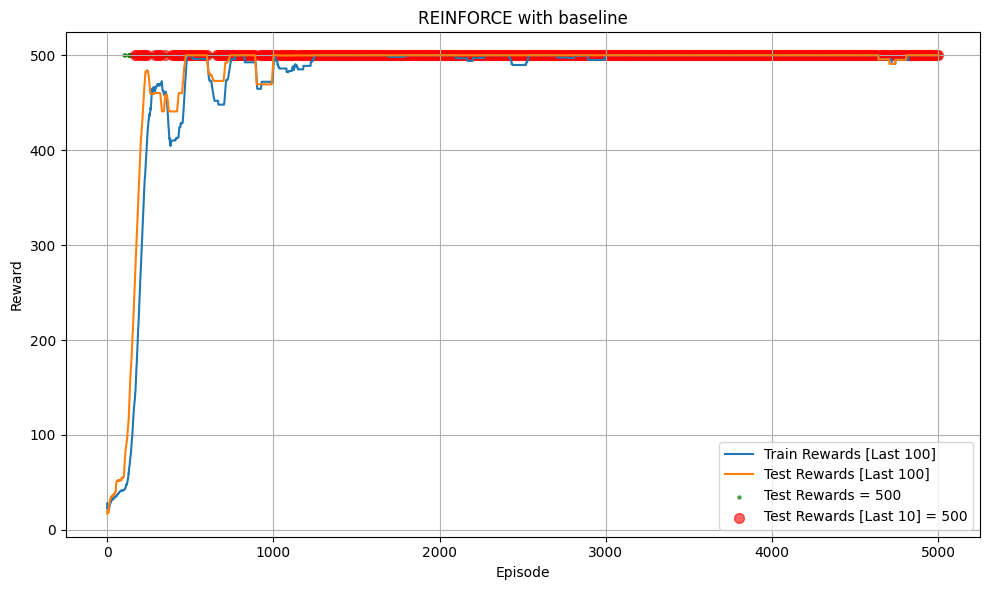

In [13]:
import matplotlib.pyplot as plt

episode_rewards = agent.episode_rewards
test_episode_rewards = agent.test_episode_rewards

train_episodes = list(range(1, len(agent.episode_rewards)+1))
test_episodes = list(range(1, len(agent.test_episode_rewards)+1, 1))
test_episodes_per_test = list(range(10, len(agent.test_episode_rewards)+1, 10))

episode_rewards = np.array(episode_rewards)
test_episode_rewards = np.array(test_episode_rewards)

mean_rewards = []
mean_test_rewards_per_test = []
mean_test_rewards_l100 = []
for i in range(len(episode_rewards)):
    mean_rewards.append(episode_rewards[max(0, i-100):i+1].mean())
for i in range(len(test_episode_rewards)):
    if (i+1) % config.num_test_episodes == 0:
        mean_test_rewards_per_test.append(test_episode_rewards[max(0, i-config.num_test_episodes):i+1].mean())
    mean_test_rewards_l100.append(test_episode_rewards[max(0, i-100):i+1].mean())

plt.figure(figsize=(10, 6))

idx_full_rewards = np.array(test_episode_rewards) == 500
idx_full_mean_rewards = np.array(mean_test_rewards_per_test) == 500

plt.plot(train_episodes, mean_rewards, label='Train Rewards [Last 100]')
plt.plot(test_episodes, mean_test_rewards_l100, label='Test Rewards [Last 100]')
plt.scatter(np.array(test_episodes)[idx_full_rewards], 
            np.array(test_episode_rewards)[idx_full_rewards], label='Test Rewards = 500', alpha=0.6, s=5, color = 'green')
plt.scatter(np.array(test_episodes_per_test)[idx_full_mean_rewards], 
            np.array(mean_test_rewards_per_test)[idx_full_mean_rewards], label='Test Rewards [Last 10] = 500', alpha=0.6, s=50, color = 'red')

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("REINFORCE with baseline")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

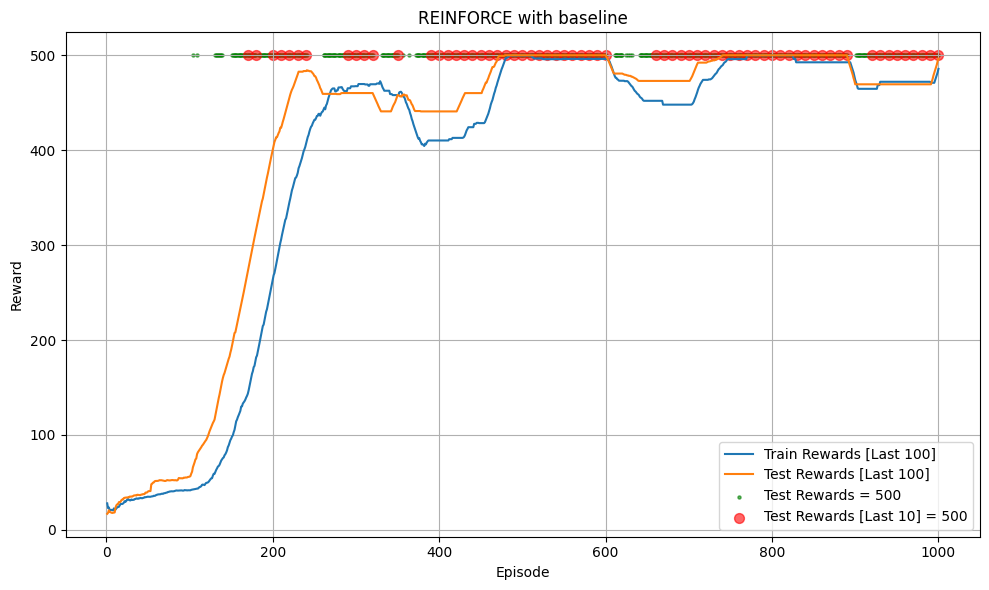

In [16]:
import matplotlib.pyplot as plt

episode_rewards = agent.episode_rewards[:1000]
test_episode_rewards = agent.test_episode_rewards[:1000]

train_episodes = list(range(1, len(episode_rewards)+1))
test_episodes = list(range(1, len(test_episode_rewards)+1, 1))
test_episodes_per_test = list(range(10, len(test_episode_rewards)+1, 10))

episode_rewards = np.array(episode_rewards)
test_episode_rewards = np.array(test_episode_rewards)

mean_rewards = []
mean_test_rewards_per_test = []
mean_test_rewards_l100 = []
for i in range(len(episode_rewards)):
    mean_rewards.append(episode_rewards[max(0, i-100):i+1].mean())
for i in range(len(test_episode_rewards)):
    if (i+1) % config.num_test_episodes == 0:
        mean_test_rewards_per_test.append(test_episode_rewards[max(0, i-config.num_test_episodes):i+1].mean())
    mean_test_rewards_l100.append(test_episode_rewards[max(0, i-100):i+1].mean())

plt.figure(figsize=(10, 6))

idx_full_rewards = np.array(test_episode_rewards) == 500
idx_full_mean_rewards = np.array(mean_test_rewards_per_test) == 500

plt.plot(train_episodes, mean_rewards, label='Train Rewards [Last 100]')
plt.plot(test_episodes, mean_test_rewards_l100, label='Test Rewards [Last 100]')
plt.scatter(np.array(test_episodes)[idx_full_rewards], 
            np.array(test_episode_rewards)[idx_full_rewards], label='Test Rewards = 500', alpha=0.6, s=5, color = 'green')
plt.scatter(np.array(test_episodes_per_test)[idx_full_mean_rewards], 
            np.array(mean_test_rewards_per_test)[idx_full_mean_rewards], label='Test Rewards [Last 10] = 500', alpha=0.6, s=50, color = 'red')

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("REINFORCE with baseline")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()